In [203]:
# from google.colab import drive
# drive.mount('/content/drive')

In [204]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Lambda, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.backend as K

In [205]:
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        # Set memory growth for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("GPU configuration successful")
except RuntimeError as e:
    print(f"GPU configuration error: {e}")

# 2. Configure mixed precision
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision configuration successful")
except Exception as e:
    print(f"Mixed precision error (non-critical): {e}")

# 3. Clear any existing sessions
tf.keras.backend.clear_session()

GPU configuration error: Physical devices cannot be modified after being initialized
Mixed precision configuration successful


In [206]:
tf.__version__

'2.10.1'

In [207]:
data_dir = '../../data/aug'

In [208]:
def load_and_preprocess_data(data_dir):
    X = []
    y = []

    # Baca data dari direktori aug
    for person_dir in os.listdir(data_dir):
        person_path = os.path.join(data_dir, person_dir)
        if os.path.isdir(person_path):
            person_id = int(person_dir.split('_')[-1])
            image_paths = glob(os.path.join(person_path, '*.jpg'))

            for image_path in image_paths:
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, (128, 128))
                image = image / 255.0  # Normalisasi ke rentang 0-1
                X.append(image)
                y.append(person_id)

    return np.array(X), np.array(y)


In [209]:
# Baca dan preprocess data
X, y = load_and_preprocess_data(data_dir)
print(f"Jumlah data: {len(X)}")
print(f"Ukuran input: {X.shape[1:]}")

Jumlah data: 640
Ukuran input: (128, 128)


In [210]:
img_width, img_height = 128, 128

In [211]:
# Fungsi untuk memuat gambar dan resize
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Membaca gambar grayscale
    img = cv2.resize(img, (img_width, img_height))  # Resize gambar
    img = img.astype('float32') / 255.0  # Normalisasi
    img = np.expand_dims(img, axis=-1)  # Menambahkan dimensi channel
    return img


In [212]:
def create_pairs(directory):
    pairs = []
    labels = []
    people = os.listdir(directory)

    for person in people:
        person_path = os.path.join(directory, person)
        images = os.listdir(person_path)
        for i in range(len(images)):
            for j in range(i + 1, len(images)):
                img1 = load_image(os.path.join(person_path, images[i]))
                img2 = load_image(os.path.join(person_path, images[j]))
                pairs.append([img1, img2])
                labels.append(1)  # Pair positif (gambar dari orang yang sama)

        for other_person in [p for p in people if p != person]:
            other_path = os.path.join(directory, other_person)
            other_image = load_image(os.path.join(other_path, os.listdir(other_path)[0]))
            pairs.append([img1, other_image])
            labels.append(0)  # Pair negatif (gambar dari orang berbeda)

    return np.array(pairs), np.array(labels)



In [213]:
# Load pasangan data
pairs, labels = create_pairs(data_dir)

# Split data menjadi training dan validation (contoh 80-20 split)
from sklearn.model_selection import train_test_split
(pairs_train, pairs_val, labels_train, labels_val) = train_test_split(pairs, labels, test_size=0.2, random_state=42)

In [214]:
print('Train pairs shape:', pairs_train.shape)
print ('Test pairs shape:', pairs_val.shape)
print ('Train labels shape:', labels_train.shape)
print ('Test labels shape:', labels_val.shape)

Train pairs shape: (5657, 2, 128, 128, 1)
Test pairs shape: (1415, 2, 128, 128, 1)
Train labels shape: (5657,)
Test labels shape: (1415,)


In [215]:
labels_train = np.array(labels_train).astype(np.float32)
labels_val = np.array(labels_val).astype(np.float32)


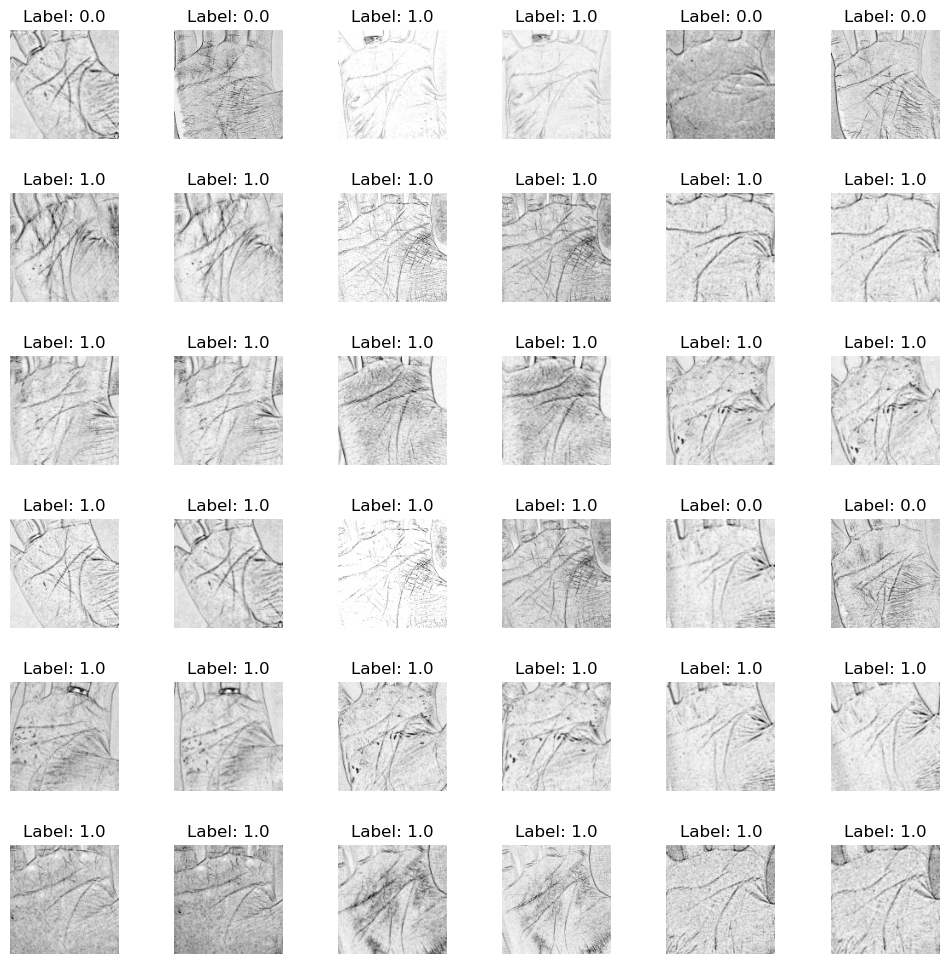

In [216]:
# Menampilkan grid pasangan gambar (pairs) dan label untuk visualisasi
import matplotlib.pyplot as plt

# Membuat grid untuk visualisasi pasangan gambar
fig, ax = plt.subplots(6, 6, figsize=(12, 12))  # 6x6 grid (12 gambar pairs)
counter = 0

for i in range(6):  # Baris grid
    for j in range(0, 6, 2):  # Kolom grid (2 gambar per pasangan)
        # Mengambil pasangan gambar dan label
        img1 = pairs_train[counter][0]  # Gambar pertama dalam pasangan
        img2 = pairs_train[counter][1]  # Gambar kedua dalam pasangan
        label = labels_train[counter]  # Label pasangan

        # Menampilkan gambar pertama
        ax[i, j].imshow(img1.squeeze(), cmap='gray')  # Gambar grayscale
        ax[i, j].set_title(f'Label: {label}')
        ax[i, j].axis('off')  # Sembunyikan axis

        # Menampilkan gambar kedua
        ax[i, j+1].imshow(img2.squeeze(), cmap='gray')  # Gambar grayscale
        ax[i, j+1].set_title(f'Label: {label}')
        ax[i, j+1].axis('off')  # Sembunyikan axis

        counter += 1  # Beralih ke pasangan berikutnya

# Menyesuaikan jarak antar subplot
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


In [217]:
def build_siamese_model(input_shape=(128, 128, 1)):
    """Build a memory-efficient siamese model that maintains learning capacity"""
    input = Input(shape=input_shape)
    
    # First convolutional block
    x = Conv2D(64, (10, 10), activation='relu')(input)
    x = MaxPooling2D()(x)
    
    # Second convolutional block
    x = Conv2D(128, (7, 7), activation='relu')(x)
    x = MaxPooling2D()(x)
    
    # Third convolutional block
    x = Conv2D(128, (4, 4), activation='relu')(x)
    x = MaxPooling2D()(x)
    
    # Fourth convolutional block
    x = Conv2D(256, (4, 4), activation='relu')(x)
    x = MaxPooling2D()(x)  # Added extra MaxPooling to reduce dimensions
    
    x = Flatten()(x)
    
    # Replace single large Dense layer with smaller sequential Dense layers
    x = Dense(2048, activation='relu', name='dense1')(x)
    
    model = Model(input, x)
    return model


In [218]:
def build_complete_model(input_shape=(128, 128, 1)):
    """Build the complete siamese network with pre-trained CNN"""
    base_network = build_siamese_model(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = Lambda(
      lambda embeddings: tf.abs(embeddings[0] - embeddings[1]),
      output_shape=lambda input_shapes: input_shapes[0]
     )([processed_a, processed_b])

    prediction = Dense(1, activation='sigmoid')(distance)
    model = Model([input_a, input_b], prediction)

    return model

In [219]:
print(pairs_train[:, 0].shape)  # Dimensi input A
print(pairs_train[:, 1].shape)  # Dimensi input B
print(labels_train.shape)       # Dimensi label


(5657, 128, 128, 1)
(5657, 128, 128, 1)
(5657,)


In [220]:
model = build_complete_model()
model.compile(loss="binary_crossentropy", optimizer=Adam(0.0001), metrics=["accuracy"])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 2048)         9585472     ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [221]:
# Callback untuk early stopping jika val_accuracy tidak meningkat
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Callback untuk mengurangi learning rate jika val_loss stagnan
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [222]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        val_loss = logs.get('val_loss')

        # Cek apakah akurasi validasi lebih dari 99% dan loss validasi lebih kecil dari 0.05
        if val_accuracy > 0.99 and val_loss < 0.05:
            print(f"\nEpoch {epoch + 1}: Validation accuracy > 99% and validation loss < 0.05, stopping training.")
            self.model.stop_training = True

callbacks = [CustomCallback()]

In [223]:
# Prepare the data
X_train = [pairs_train[:, 0], pairs_train[:, 1]]
X_test = [pairs_val[:, 0], pairs_val[:, 1]]
y_train = labels_train.astype('float32')
y_test = labels_val.astype('float32')


In [224]:
# Training model
with tf.device('/GPU:0'):
    history = model.fit(
        X_train, 
        y_train,
        validation_data=(X_test, y_test),
        batch_size=16,
        epochs=70
    )

Epoch 1/70
354/354 [==============================] - 40s 107ms/step - loss: 0.4060 - accuracy: 0.8577 - val_loss: 0.3696 - val_accuracy: 0.8643
Epoch 2/70
354/354 [==============================] - 37s 104ms/step - loss: 0.3176 - accuracy: 0.8872 - val_loss: 0.2103 - val_accuracy: 0.9300
Epoch 3/70
354/354 [==============================] - 36s 102ms/step - loss: 0.1309 - accuracy: 0.9643 - val_loss: 0.0695 - val_accuracy: 0.9809
Epoch 4/70
354/354 [==============================] - 37s 104ms/step - loss: 0.0539 - accuracy: 0.9876 - val_loss: 0.0347 - val_accuracy: 0.9943
Epoch 5/70
354/354 [==============================] - 37s 104ms/step - loss: 0.0195 - accuracy: 0.9970 - val_loss: 0.0205 - val_accuracy: 0.9958
Epoch 6/70
354/354 [==============================] - 37s 105ms/step - loss: 0.0262 - accuracy: 0.9938 - val_loss: 0.0238 - val_accuracy: 0.9972
Epoch 7/70
354/354 [==============================] - 37s 104ms/step - loss: 0.0104 - accuracy: 0.9982 - val_loss: 0.0164 - val_ac

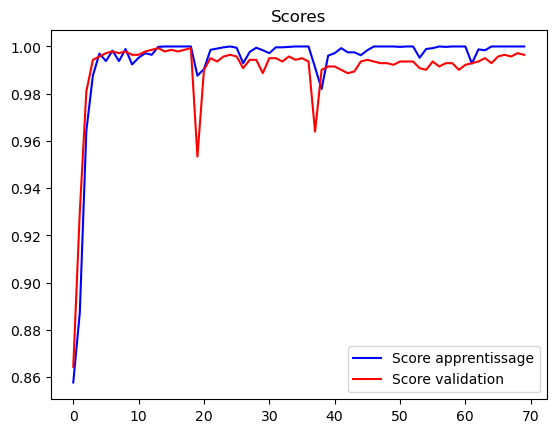

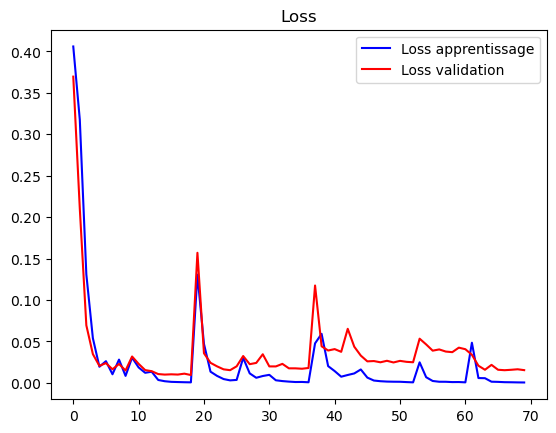

In [225]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()
def plot_loss(train):
    loss = train.history['loss']
    val_loss = train.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label='Loss apprentissage')
    plt.plot(epochs, val_loss, 'r', label='Loss validation')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_scores(history)
plot_loss(history)

In [226]:
model_json = model.to_json()
#.json is the architecture
with open("palm_print_siamese_model.json", "w") as json_file:
    json_file.write(model_json)
#.h5 is the weights of the model
model.save('palm_print_siamese_model.h5')

model.load_weights('palm_print_siamese_model.h5')